In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',encoding='ISO-8859-1')

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Preliminary analysis


In [5]:
print('Total number of customers is:', df['CustomerID'].nunique())
print('Total number of transactions that occured is:', df['InvoiceNo'].nunique())
print('Total number of products sold is:', df['StockCode'].nunique())

Total number of customers is: 4372
Total number of transactions that occured is: 25900
Total number of products sold is: 4070


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Sales        541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.2+ MB


## Orders by Country

In [7]:
print('Orders came from ',df['Country'].nunique(),'different countries.')

Orders came from  38 different countries.


In [8]:
customers_by_countries = df.copy()
customers_by_countries.drop_duplicates(subset=['CustomerID'],inplace = True)
countries = customers_by_countries['Country'].value_counts()
countries

United Kingdom          3951
Germany                   95
France                    87
Spain                     29
Belgium                   24
Switzerland               20
Portugal                  19
Italy                     15
Finland                   12
Norway                    10
Netherlands                9
Australia                  9
Austria                    9
Channel Islands            9
Japan                      8
Denmark                    8
Sweden                     8
Cyprus                     7
Poland                     6
Canada                     4
Israel                     4
USA                        4
Unspecified                4
Greece                     4
EIRE                       3
Malta                      2
United Arab Emirates       2
Bahrain                    2
RSA                        1
Saudi Arabia               1
Czech Republic             1
Singapore                  1
Brazil                     1
Lebanon                    1
Iceland       

We can see that maximum orders came from United Kingdom

## Monthly Sales analysis

In [9]:
df['monthly sales'] = pd.to_datetime(df['InvoiceDate']).dt.strftime('%Y-%m')
monthly_sales = df.groupby(['monthly sales'],as_index = False).agg({'Sales':'sum'})
monthly_sales

,monthly sales,Sales
0,2010-12,748957.020
1,2011-01,560000.260
2,2011-02,498062.650
3,2011-03,683267.080
4,2011-04,493207.121
5,2011-05,723333.510
6,2011-06,691123.120
7,2011-07,681300.111
8,2011-08,682680.510
9,2011-09,1019687.622


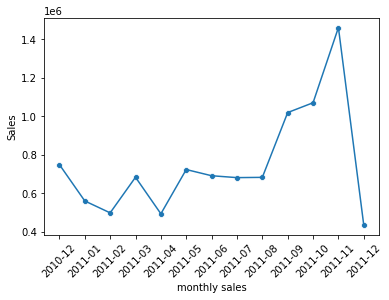

In [10]:
sns.lineplot(monthly_sales['monthly sales'],monthly_sales['Sales'])
sns.scatterplot(monthly_sales['monthly sales'],monthly_sales['Sales'])
plt.xticks(rotation = 45);

Sales increased and decreased for almost every month in the beginning, but since June,2011 the sales gradually starting rising until the maximum sales took place in the month November-2011 (2011-11).

## Grouping customers


In [11]:
customers = df.groupby(['CustomerID'],as_index = False).agg({'Sales':'sum','InvoiceNo':'count','Country':'first'})
customers

,CustomerID,Sales,InvoiceNo,Country
0,12346.0,0.00,2,United Kingdom
1,12347.0,4310.00,182,Iceland
2,12348.0,1797.24,31,Finland
3,12349.0,1757.55,73,Italy
4,12350.0,334.40,17,Norway
...,...,...,...,...
4367,18280.0,180.60,10,United Kingdom
4368,18281.0,80.82,7,United Kingdom
4369,18282.0,176.60,13,United Kingdom
4370,18283.0,2094.88,756,United Kingdom


In [12]:
encoder = LabelEncoder()
customers['Country'] = encoder.fit_transform(customers['Country'])

In [13]:
X = customers[['Sales','InvoiceNo','Country']]
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i,random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

print(pd.DataFrame(inertias,columns=['inertia_values']))

   inertia_values
0    2.955308e+11
1    1.002318e+11
2    4.937286e+10
3    3.038788e+10
4    1.803228e+10
5    1.178084e+10
6    8.568577e+09
7    5.657027e+09
8    4.179069e+09
9    3.252976e+09


Text(0.5, 1.0, 'Number of clusters vs inertia values')

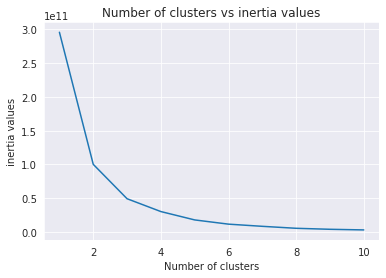

In [14]:
sns.set_style('darkgrid')
sns.lineplot(range(1,11),inertias)
plt.xlabel('Number of clusters')
plt.ylabel('inertia values')
plt.title('Number of clusters vs inertia values')

Optimum cluster number can be seen to be 3

In [15]:
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=0)

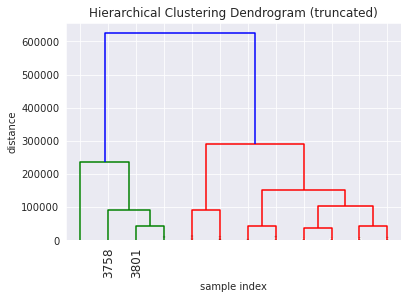

In [16]:
Z = linkage(X, method='ward',metric='euclidean')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z,truncate_mode='lastp',p=12,show_leaf_counts=False,  
            leaf_rotation=90.,leaf_font_size=12.,show_contracted=True,)
plt.show()